In [58]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [153]:
import numpy as np
import pandas as pd
from scipy import stats

In [60]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [61]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [62]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [63]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [64]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [65]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [66]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Here I just want to look at the columns available in each table

In [67]:
# Review columns in Measurment table
Measurement.__table__.columns.values()


[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [68]:
# Review columns in Station table
Station.__table__.columns.values()

[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

# Exploratory Climate Analysis
### Look at the precipitation data for the last 12 months of data available

In [69]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
date_1yrago = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores

precip = session.query(Measurement.date.label("Date"), 
                    Measurement.prcp.label("Precipitation")).filter(Measurement.date>=date_1yrago).order_by(Measurement.date)
              

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.read_sql(precip.statement, engine)
precip_df = precip_df.set_index("Date")


# Sort the dataframe by date

precip_df=precip_df.sort_values(by=['Date'])

# Check for missing data

precip_df.isna().sum()

# There were 208 NaN's.  Since I have no way to check on these, I am going to drop them as I 
# don't want to assume they are zero.

precip_df=precip_df.dropna()
precip_df.head()


,Precipitation
Date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


### Plot the precipation data and look at summary statistics
#### Note this plot is a bit odd, as we have multiple stations, so we are plotting precip by data and by station, but that is what was asked in the homework

[]

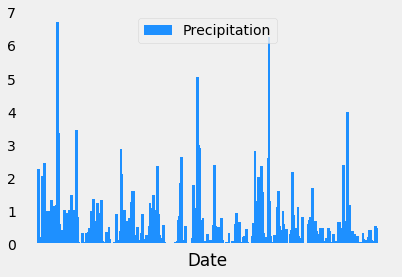

In [211]:
# Use Pandas Plotting with Matplotlib to plot the data

fig, ax=plt.subplots()

Precip=precip_df['Precipitation']
Date=precip_df.index


ax.bar(x=Date,height=Precip, color='dodgerblue', width=3, label='Precipitation')

# Why the gridlines won't display is a mystery
ax.grid()
ax.legend(loc='upper center')
ax.set_xlabel('Date')
ax.set_xticklabels([])


In [71]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


### Calcuate number of stations

In [72]:
# Design a query to show the total number of stations

stations = session.query(Measurement.station).group_by(Measurement.station).count()

print(f"The total number of Stations is {stations}")


The total number of Stations is 9


### Calculate the number of observations per station and list in descending order

In [74]:
# Query to find the most active stations.  Count the number of measurment id's per station and
# output in descending order.

activity = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station). \
            order_by(func.count(Measurement.id).desc())

# Print the station and count data

print(f"Stations and number of observations from most active to least active:")
for a in activity:
    print(a)



Stations and number of observations from most active to least active:
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


### Find the station with the highest observation count

In [24]:
# Find Station with the highest observation count.  Order by the count of id's per station, sort by
# descending order and output the first, which will be the staton with the higher observation count.

highestcount=session.query(Measurement.station).group_by(Measurement.station). \
            order_by(func.count(Measurement.id).desc()).first()

# Unpack the tuple result so it can be used as a variable

activestation, = highestcount

# Print out the station number.

print(f"The station with the highest observation count is {activestation}")


The station with the highest observation count is USC00519281


### Get the temperatures for the last year available for the station with the highest observation count and create a histogram of the temperature observations

Text(0.5, 1.0, 'Number of Observation Within Each Temp Range for Station USC00519281')

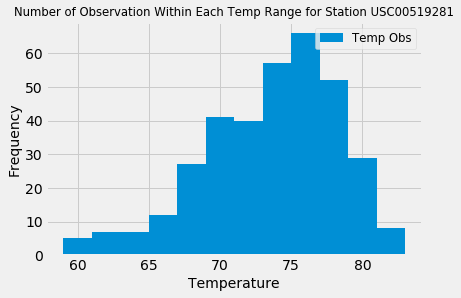

In [214]:
# Query temperature measurement for the last year for the station with the highest number of observations

temps = session.query(Measurement.station , Measurement.date, Measurement.tobs).filter(Measurement.date>=date_1yrago). \
                  filter(Measurement.station == activestation).all()

# Unpack the list of tuples

templist= list(zip(*temps))

# Assign list elements to variables

station1, date1, temp1 = templist

# Create a histogram of the temperatures

fig, ax = plt.subplots()

ax.hist(temp1, bins=12, label='Temp Obs')
ax.legend(loc='upper right', fontsize='small')
ax.set_ylabel('Frequency', fontsize='medium')
ax.set_xlabel('Temperature', fontsize='medium')
ax.set_title(f"Number of Observation Within Each Temp Range for Station {activestation}", fontsize='small')

### The following is all part of the optional homework

### Temperature Analysis I:  Compare June temps to December temps using paired t-test

In [215]:
# Query station, data, and temperature
tempcompare=session.query(Measurement.station, Measurement.date, Measurement.tobs). \
            order_by(Measurement.station).order_by(Measurement.date)

# convert to a dataframe
tempcompare_df = pd.read_sql(tempcompare.statement, engine)


##### Rationale for using paired t-test
# Since we have measurements at different times for the same station, I will use a paired t-test
# To accomplish this is I create dataframes for June and December and then merge them together
# by station, year, and day to have pairs.  Alternately, I could had calculated the monthly
# average for each year and then merged by station, year, month.  In any case, you need to
# insure that you have values for both June and December for each year, so I do an inner join.


tempcompare_df['Month'] = tempcompare_df['date'].str.slice(5,7,1)
tempcompare_df['Day'] = tempcompare_df['date'].str.slice(8,10,1)
tempcompare_df['Year'] = tempcompare_df['date'].str.slice(0,4,1)

june_df = tempcompare_df[(tempcompare_df['Month'] == '06')]

jun_gb_df = june_df.groupby

dec_df = tempcompare_df[(tempcompare_df['Month'] == '12')]



combined_df=pd.merge(june_df, dec_df, left_on=('station','Year','Day'), right_on=('station','Year','Day'), how='inner', suffixes=('_jun', '_dec'))

combined_df.describe()


(t_stat, p) = stats.ttest_rel(combined_df['tobs_jun'], combined_df['tobs_dec'])

print(f"The p-value of the paired t-test is {round(p,4)}, which is statistically significant")

print()
print(f"Based on the statistics below, it is sigificantly warmer in June. Although either month would be a good time to visit")
print()
print(combined_df.describe())

The p-value of the paired t-test is 0.0, which is statistically significant

Based on the statistics below, it is sigificantly warmer in June. Although either month would be a good time to visit

          tobs_jun     tobs_dec
count  1358.000000  1358.000000
mean     74.676730    71.022091
std       3.193938     3.640975
min      64.000000    57.000000
25%      72.000000    69.000000
50%      75.000000    71.000000
75%      77.000000    74.000000
max      85.000000    83.000000


### Temperature Analysis II:  Look at last year's temps for same date as my upcoming trip

In [216]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
# print(calc_temps('2012-02-28', '2012-03-05'))

<ErrorbarContainer object of 3 artists>

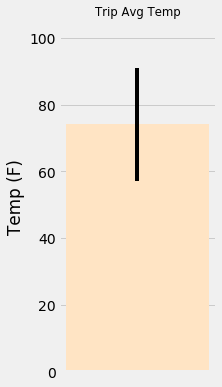

In [217]:
# I am going to pretend like I am back in May of 2017(since the data stops in Aug-2017) and I am planning
# a trip for Jun 1st to Jun 15, so I will look at these same date from back in 2016 to see how the weather looked

tempresult = calc_temps('2016-06-01','2016-06-15')

templist= list(np.ravel(tempresult))
tempmin, tempavg, tempmax = templist

errorrange = tempmax - tempmin


# Create a barchart to show the averae, as well as errobar that show min/max

fig, ax=plt.subplots(figsize=(2.5,6))

ax.bar(x=1,height=tempavg, color='bisque')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.set_ylim(0, 105)
ax.grid(axis='x')
ax.set_ylabel('Temp (F)')
ax.set_title('Trip Avg Temp', fontsize='small')
ax.errorbar(x=1,y=tempavg, yerr=errorrange, color='black')

## That is as far as I got on the optional analysis.  This assignment was quite time consuming.  Everything below was provided in the sample file.  I left it in here so I could maybe look at it later.

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


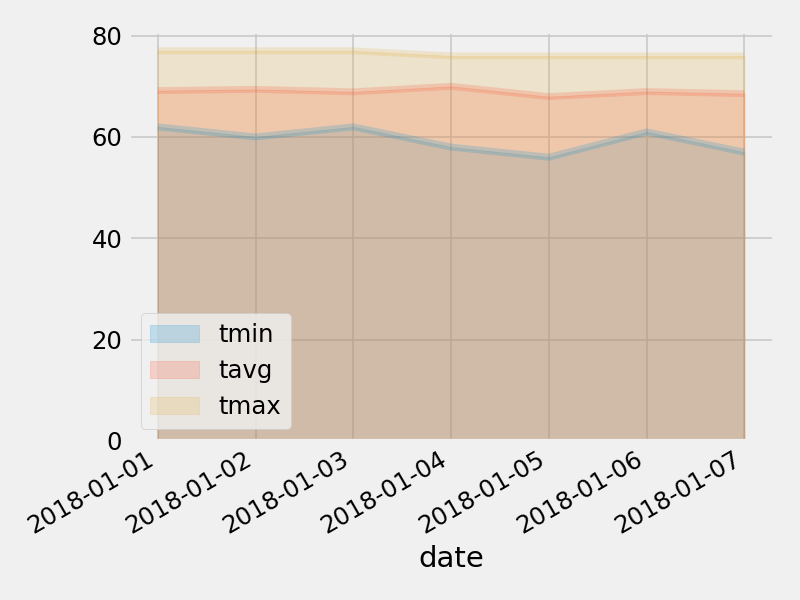

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
